### Libraries

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import texthero as hero
from texthero import preprocessing
sb.set() # set the default Seaborn style for graphics
from matplotlib.ticker import FuncFormatter, MaxNLocator
import matplotlib.dates as mdates

### Chunking CSV to upload onto GitHub

import pandas as pd

chunk_size = 55000
batch_no = 1

for chunk in pd.read_csv('221100_DayZ.csv', chunksize=chunk_size):
    #chunk.to_csv('221100_DayZ' + str(batch_no) + '.csv', index=False)
    #batch_no +=1

### Dataset

In [2]:
steamData = pd.read_csv('steam_data/steam.csv')
steamSupportInfo = pd.read_csv('steam_data/steam_support_info.csv')
steamChart = pd.read_csv('steam_data/steamCharts.csv')
steamSpyTagData = pd.read_csv('steam_data/steamspy_tag_data.csv')
steamGames = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_games/steam_games*.csv"))))
steamMediaData = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_media_data/steam_media_data*.csv"))))
steamRequirements = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_requirements/steam_requirements*.csv"))))
steamDescription = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_description/steam_description*.csv"))))

#game reviews
steam_HalfOfTheGameReviews = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_reviews/steam_review_*.csv"))))
files = glob.glob("steam_data/steam_reviews" + '**/**' + "/*.csv")
steamReviews_fromFolder = pd.concat([pd.read_csv(f) for f in files ])
steamReviewsDF = [steam_HalfOfTheGameReviews, steamReviews_fromFolder]
steamCombinedReviews = pd.concat(steamReviewsDF)

#steamCombinedReviews

C:\Users\Pyae Pyae\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Pyae Pyae\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Pyae Pyae\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\Pyae Pyae\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### Cleaning the Dataset

In [3]:
#rename for easier identification
steamGames = steamGames.rename(columns={"name": "title"})

#drop columns
steamCombinedReviews = steamCombinedReviews[["title", "review", "voted_up"]]
steamCombinedReviews

,title,review,voted_up
0,7 Days to Die,turd,True
1,7 Days to Die,this is a great game and I hope more people wi...,True
2,7 Days to Die,Good game,True
3,7 Days to Die,Haha bat hit zombie and zombie head explode,True
4,7 Days to Die,ZOMBIE GO GRRR GUN GO BRRRRRR,True
...,...,...,...
386,The Elder Scrolls V Skyrim,Epic!,True
387,The Elder Scrolls V Skyrim,This game...,True
388,The Elder Scrolls V Skyrim,"Waifu Simulator 2011, OH THANK YOU BETHESDA.",True
389,The Elder Scrolls V Skyrim,"GET IT YOU GNOMERS! :P Fourms be damned, Skyri...",True


In [4]:
#steamReviews_1 = steamCombinedReviews.iloc[:1000000,:]
#steamReviews_2 = steamCombinedReviews.iloc[1000000:2000000,:]
#steamReviews_3 = steamCombinedReviews.iloc[2000000:3000000,:]
#steamReviews_3 = steamCombinedReviews.iloc[30000000:,:]

In [5]:
steamReviews_1 = steamCombinedReviews.iloc[:50,:]

In [6]:
chunks = list()
chunk_size = 10
num_chunks = len(steamReviews_1) // chunk_size + 1
for i in range(num_chunks):
    chunks.append(steamReviews_1[i*chunk_size:(i+1)*chunk_size])

In [7]:
#chunks = list()
#chunk_size = 100000
#num_chunks = len(steamCombinedReviews) // chunk_size + 1
#for i in range(num_chunks):
    #chunks.append(steamCombinedReviews[i*chunk_size:(i+1)*chunk_size])

In [8]:
len(chunks)

6

In [9]:
chunks

[           title                                             review  voted_up
 0  7 Days to Die                                               turd      True
 1  7 Days to Die  this is a great game and I hope more people wi...      True
 2  7 Days to Die                                          Good game      True
 3  7 Days to Die        Haha bat hit zombie and zombie head explode      True
 4  7 Days to Die                      ZOMBIE GO GRRR GUN GO BRRRRRR      True
 5  7 Days to Die                         I tthot thare wood be blox     False
 6  7 Days to Die                                       Great game!!      True
 7  7 Days to Die  Fun game, great with friends, good by yourself...      True
 8  7 Days to Die                                       shit is dope      True
 9  7 Days to Die                             Great game, recommend.      True,
             title                                             review  voted_up
 10  7 Days to Die  It was good game back then,but

In [10]:
#create a custom cleaning pipeline
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace]

steamCombinedReviews['title'] = hero.clean(steamCombinedReviews['title'], pipeline = custom_pipeline)
#steamCombinedReviews['clean_review'] = hero.clean(steamCombinedReviews['review'], pipeline = custom_pipeline)
steamGames['title'] = hero.clean(steamGames['title'], pipeline = custom_pipeline)
steamData['title'] = hero.clean(steamData['name'], pipeline = custom_pipeline)

In [11]:
from texthero import stopwords
default_stopwords = stopwords.DEFAULT
custom_stopwords = default_stopwords.union(set(["game","mods"]))


custom_pipeline_review = [preprocessing.fillna
                          , preprocessing.lowercase
                          , preprocessing.remove_punctuation
                          , preprocessing.remove_diacritics
                          , preprocessing.remove_whitespace
                          , preprocessing.drop_no_content]

#steamCombinedReviews['clean_review'] = hero.clean(steamCombinedReviews['review'], pipeline = custom_pipeline_review)

for dataframeTest in chunks:
    dataframeTest.review = hero.clean(dataframeTest.review, pipeline = custom_pipeline_review)
    #dataframeTest.review = hero.remove_stopwords(dataframeTest.review, custom_stopwords)


C:\Users\Pyae Pyae\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
df = pd.concat(chunks)

In [13]:
df

,title,review,voted_up
0,7 days to die,turd,True
1,7 days to die,this is a great game and i hope more people wi...,True
2,7 days to die,good game,True
3,7 days to die,haha bat hit zombie and zombie head explode,True
4,7 days to die,zombie go grrr gun go brrrrrr,True
5,7 days to die,i tthot thare wood be blox,False
6,7 days to die,great game,True
7,7 days to die,fun game great with friends good by yourself c...,True
8,7 days to die,shit is dope,True
9,7 days to die,great game recommend,True


In [14]:
#testing.to_frame()

In [15]:
#tw = hero.visualization.top_words(testing).head(50)
#import plotly.express as px
#fig = px.bar(tw)
#fig.show()
#tw.head()

Some popular words that can be observed here include “taste,” “product,” “love,” and “Amazon.” These words are mostly positive, also indicating that most reviews in the dataset express a positive sentiment.

##### Getting title, genre, release date, reviews and ratings

In [16]:
#getting title and genre from steamGames df
steamGames_Title_Genre = steamGames[['title', 'genre', 'release_date']]

#getting title and review from steamCombinedReviews df
#steamCombinedReviews_Title_Reviews = steamCombinedReviews[['title', 'review', 'clean_content']]

#getting title and rating from steamData df
steamData_Title_Rating = steamData[['title', 'genres', 'positive_ratings', 'negative_ratings']]
steamData_Title_Rating = steamData_Title_Rating.rename(columns={'genres': 'genre'})


##### matching title

In [17]:
#Genre
matchTitleGenre = steamGames_Title_Genre.title.isin(steamCombinedReviews.title)
steamMatchTitleGenre = steamGames_Title_Genre[matchTitleGenre]

#Rating
matchTitleRating = steamData_Title_Rating.title.isin(steamCombinedReviews.title)
steamMatchTitleRating = steamData_Title_Rating[matchTitleRating]


##### dropping duplicate values

In [18]:
#Genre
steamUniqueTitleGenre = steamMatchTitleGenre.drop_duplicates(['title'])
steamUniqueTitleGenre = steamUniqueTitleGenre.reset_index(drop=True)

#Rating
steamUniqueTitleRating = steamMatchTitleRating.reset_index(drop=True)

#Drop nan rows
nan_value = float("NaN")
steamUniqueTitleGenre.replace("", nan_value, inplace=True)
steamUniqueTitleGenre.dropna(subset = ["genre"], inplace=True)

steamUniqueTitleRating.replace("", nan_value, inplace=True)
steamUniqueTitleRating.dropna(subset = ["title"], inplace=True)

##### remove values that we don't use

In [19]:
#Genre
steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace(',Early Access?', '')
steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace('Early Access,?', '')
steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace(',Massively Multiplayer?', '')
steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace('Massively Multiplayer,?', '')
steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace(',Free to Play?', '')
steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace('Free to Play,?', '')

steamUniqueTitleGenre['release_date'] = steamUniqueTitleGenre.release_date.str.replace('Early Access' , '')
steamUniqueTitleGenre['release_date'] = steamUniqueTitleGenre.release_date.str.replace('Coming Soon' , '')
steamUniqueTitleGenre['release_date'] = steamUniqueTitleGenre.release_date.str.replace('To Be Announced' , '')

#steamUniqueTitleGenre.to_excel("steamUniqueTitleGenre.xlsx")

#Rating
steamUniqueTitleRating['genre'] = steamUniqueTitleRating.genre.str.replace(';Early Access?', '')
steamUniqueTitleRating['genre'] = steamUniqueTitleRating.genre.str.replace('Early Access;?', '')
steamUniqueTitleRating['genre'] = steamUniqueTitleRating.genre.str.replace(';Massively Multiplayer?', '')
steamUniqueTitleRating['genre'] = steamUniqueTitleRating.genre.str.replace('Massively Multiplayer;?', '')
steamUniqueTitleRating['genre'] = steamUniqueTitleRating.genre.str.replace(';Free to Play?', '')
steamUniqueTitleRating['genre'] = steamUniqueTitleRating.genre.str.replace('Free to Play;?', '')

#steamUniqueTitleRating.to_excel("steamUniqueTitleRating.xlsx")

<ipython-input-19-c1396086d915>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace(',Early Access?', '')
<ipython-input-19-c1396086d915>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace('Early Access,?', '')
<ipython-input-19-c1396086d915>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace(',Massively Multiplayer?', '')
<ipython-input-19-c1396086d915>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace('Massively Multiplayer,?', '')
<ipython-input-19-c1396086d915>:6: FutureWarning: The default value of regex w

### Genre

##### split genre into 6 columns

In [20]:
steamUniqueTitleGenre[['genre1', 'genre2', 'genre3','genre4','genre5','genre6']] = steamUniqueTitleGenre['genre'].str.split(',', expand=True)

##### dropping genre, title, and release date columns to get the total count of genre

In [21]:
steamGenreCount = steamUniqueTitleGenre.drop(columns=['genre','title', 'release_date'])

##### reset index and rename the column

In [22]:
steamGenreGraph = steamGenreCount.stack().value_counts().reset_index()
steamGenreGraph.columns = ['genre','count']
steamGenreGraph

,genre,count
0,Action,73
1,Simulation,50
2,Indie,50
3,Strategy,45
4,Adventure,40
5,RPG,32
6,Sports,6
7,Casual,5
8,Racing,4


##### graph to see which genre is most popular 

<AxesSubplot:xlabel='genre', ylabel='count'>

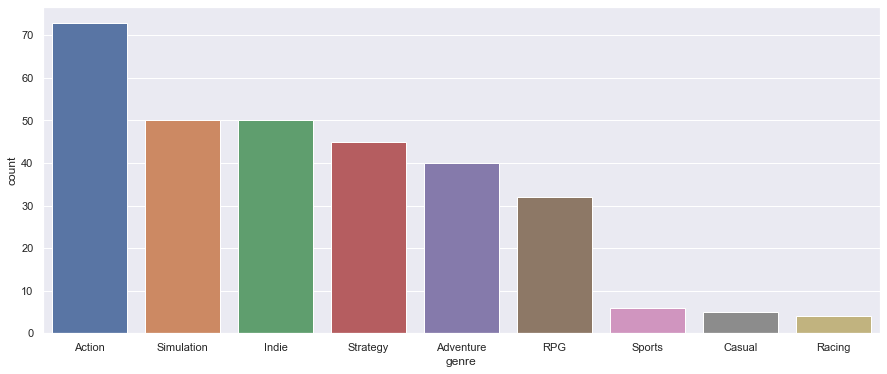

In [23]:
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sb.barplot(x="genre", y="count", data=steamGenreGraph, ax=ax)

we can see that most of the games' genres are action, indie and simulation

In [24]:
# storing last 4 letters of release_date as year
steamGenre_Date = steamUniqueTitleGenre
steamGenre_Date['year'] = steamGenre_Date['release_date'].str.slice(-4)

#dropping unused columns
steamGenre_Date = steamUniqueTitleGenre.drop(columns=['title', 'genre1', 'genre2', 'genre3','genre4','genre5','genre6'])
steamGenre_Date

,genre,release_date,year
0,"Action,Adventure","Dec 21, 2017",2017
1,"Action,Adventure,Strategy","Apr 24, 2018",2018
2,"Action,Adventure","Dec 13, 2018",2018
3,"Adventure,Indie","Jul 22, 2016",2016
4,Strategy,"Dec 12, 2017",2017
...,...,...,...
135,"Action,Adventure,RPG","Dec 22, 2018",2018
136,Action,"Feb 14, 2019",2019
137,"Simulation,Strategy",Q4 2019,2019
138,Action,,


##### storing the top 3 genre individually

In [25]:
action =steamGenre_Date.loc[steamGenre_Date['genre'].str.contains("action", case=False)]
indie =steamGenre_Date.loc[steamGenre_Date['genre'].str.contains("indie", case=False)]
simulation = steamGenre_Date.loc[steamGenre_Date['genre'].str.contains("simulation", case=False)]

##### converting year to int

In [26]:
action["year"] = pd.to_numeric(action["year"])
indie["year"] = pd.to_numeric(indie["year"])
simulation["year"] = pd.to_numeric(simulation["year"])

action["year"] = action["year"].fillna(0.0).astype(int)
indie["year"] = indie["year"].fillna(0.0).astype(int)
simulation["year"] = simulation["year"].fillna(0.0).astype(int)

<ipython-input-26-3eebed6f4e11>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  action["year"] = pd.to_numeric(action["year"])
<ipython-input-26-3eebed6f4e11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indie["year"] = pd.to_numeric(indie["year"])
<ipython-input-26-3eebed6f4e11>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

##### dropping rows that has 2020 in "year" column because it is outlier

In [27]:
# Get names of indexes for which column action has value 2020
indexAction = action[action['year'] == 2020].index
# Delete these row indexes from dataFrame
indexAction = action.drop(indexAction , inplace=True)

# Get names of indexes for which indie action has value 2020
indexIndie = indie[indie['year'] == 2020].index
# Delete these row indexes from dataFrame
indexIndie = indie.drop(indexIndie , inplace=True)

# Get names of indexes for which column simulation has value 2020
indexSimulation = simulation[simulation['year'] == 2020].index
# Delete these row indexes from dataFrame
indexIndie = simulation.drop(indexSimulation , inplace=True)


C:\Users\Pyae Pyae\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Pyae Pyae\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Pyae Pyae\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


##### grouping data based on year

In [28]:
groupedAction = action.groupby("year").count()
groupedIndie = indie.groupby("year").count()
groupedSimulation = simulation.groupby("year").count()

#reset index
groupedAction.reset_index(inplace=True)
groupedIndie.reset_index(inplace=True)
groupedSimulation.reset_index(inplace=True)

##### rename and convert the count to corresponding genre

In [29]:
groupedAction = groupedAction.rename(columns={'genre': 'action count'})  # old method  
groupedAction['action count'] = groupedAction['action count'].astype(int)

groupedIndie = groupedIndie.rename(columns={'genre': 'indie count'})  # old method  
groupedIndie['indie count'] = groupedIndie['indie count'].astype(int)

groupedSimulation = groupedSimulation.rename(columns={'genre': 'simulation count'})  # old method  
groupedSimulation['simulation count'] = groupedSimulation['simulation count'].astype(int)

#drop "release_date" column
groupedAction = groupedAction.drop(columns=['release_date'])
groupedIndie = groupedIndie.drop(columns=['release_date'])
groupedSimulation = groupedSimulation.drop(columns=['release_date'])


##### merge the top 3 dataframes into one for lineplot

In [30]:
genreTimeLine = groupedAction.merge(groupedIndie,on='year').merge(groupedSimulation,on='year')
genreTimeLine

,year,action count,indie count,simulation count
0,2012,1,2,2
1,2013,3,1,3
2,2014,3,3,3
3,2015,10,5,7
4,2016,10,11,8
5,2017,10,5,4
6,2018,19,13,13
7,2019,10,8,7


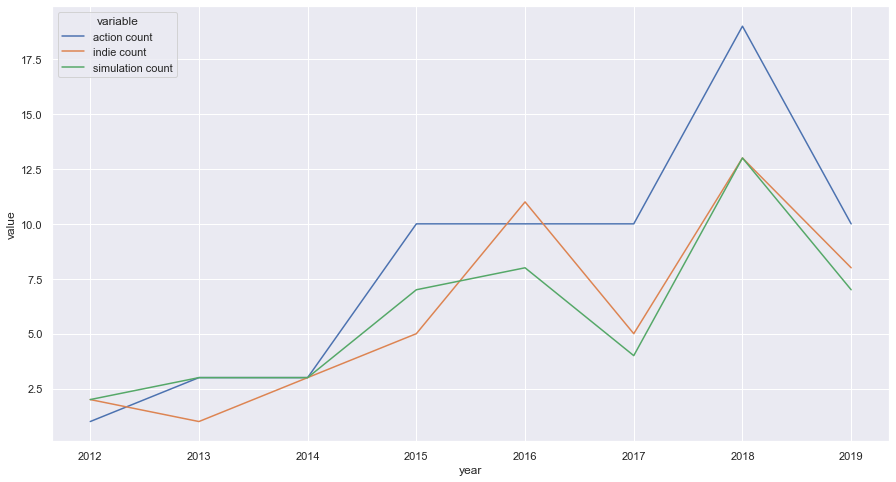

In [31]:
plt.figure(figsize=(15,8))
sb.lineplot(x='year', y='value', hue='variable', 
             data=pd.melt(genreTimeLine, ['year']))

ya = ax.get_yaxis()
ya.set_major_locator(MaxNLocator(integer=True))

xa = ax.get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

plt.show()

 We can see that there is a sharp drop in 2019. 
 
 Based on this article, https://gamedaily.biz/article/1489/year-over-year-game-release-numbers-slowed-for-steam-in-2019 , they also said that there is a drop 2019 which is the same as the graph shown above. They mentioned that the drop may be due to the Steam’s notoriously-difficultmarketing and discoverability environment.

### Rating 

In [32]:
steamUniqueTitleRating

,title,genre,positive_ratings,negative_ratings
0,counter strike,Action,124534,3339
1,counter strike source,Action,76640,3497
2,left 4 dead 2,Action,251789,8418
3,portal 2,Action;Adventure,138220,1891
4,sid meier s civilization(r) iii complete,Strategy,2578,405
...,...,...,...,...
120,atlas,Action;Adventure;RPG,8621,16359
121,hitman(tm) 2,Action,10814,1756
122,football manager 2019,Simulation;Sports,2963,1004
123,among us,Casual,60,11


##### getting total ratings

In [33]:
#sum_column = steamUniqueTitleRating["positive_ratings"] + steamUniqueTitleRating["negative_ratings"]
#steamUniqueTitleRating["total_ratings"] = sum_column
#steamUniqueTitleRating

# sort the dataframe based on total_ratings
#steamUniqueTitleRating.sort_values(by=['total_ratings'], ascending=False)

In [34]:
#top5_Rating = steamUniqueTitleRating.nlargest(5,['total_ratings'])
#below5_Rating = steamUniqueTitleRating.nsmallest(5,['total_ratings'])

In [35]:
#frames = [top5_Rating, below5_Rating]
#ratingDF = pd.concat(frames)

In [36]:
action = steamUniqueTitleRating.loc[steamUniqueTitleRating['genre'].str.contains("action", case=False)]
indie =steamUniqueTitleRating.loc[steamUniqueTitleRating['genre'].str.contains("indie", case=False)]
simulation = steamUniqueTitleRating.loc[steamUniqueTitleRating['genre'].str.contains("simulation", case=False)]
strategy = steamUniqueTitleRating.loc[steamUniqueTitleRating['genre'].str.contains("strategy", case=False)]
rpg = steamUniqueTitleRating.loc[steamUniqueTitleRating['genre'].str.contains("rpg", case=False)]
sports = steamUniqueTitleRating.loc[steamUniqueTitleRating['genre'].str.contains("sports", case=False)]
racing = steamUniqueTitleRating.loc[steamUniqueTitleRating['genre'].str.contains("racing", case=False)]

In [37]:
action

,title,genre,positive_ratings,negative_ratings
0,counter strike,Action,124534,3339
1,counter strike source,Action,76640,3497
2,left 4 dead 2,Action,251789,8418
3,portal 2,Action;Adventure,138220,1891
9,mount blade warband,Action;RPG,75872,2213
...,...,...,...,...
113,dragon ball fighterz,Action,10441,2264
117,assassin s creed(r) odyssey,Action;Adventure;RPG,20771,4528
118,sekiro(tm) shadows die twice,Action;Adventure,21504,3019
120,atlas,Action;Adventure;RPG,8621,16359


##### summing all the postive rating and negative rating separately

In [38]:
#action
action_posRating = action['positive_ratings'].sum()    
action_negRating = action['negative_ratings'].sum() 

#indie
indie_posRating = indie['positive_ratings'].sum()    
indie_negRating = indie['negative_ratings'].sum()  

#simulation
simulation_posRating = simulation['positive_ratings'].sum()    
simulation_negRating = simulation['negative_ratings'].sum() 

#strategy
strategy_posRating = strategy['positive_ratings'].sum()    
strategy_negRating = strategy['negative_ratings'].sum()

#rpg
rpg_posRating = rpg['positive_ratings'].sum()    
rpg_negRating = rpg['negative_ratings'].sum()

#sports
sports_posRating = sports['positive_ratings'].sum()    
sports_negRating = sports['negative_ratings'].sum()

#racing
racing_posRating = sports['positive_ratings'].sum()    
racing_negRating = sports['negative_ratings'].sum()

In [39]:
# initialize data of lists.
data = {'genre':['action', 'indie', 'simulation', 'strategy', 'rpg', 'sports', 'racing'],
        'positive_ratings':[action_posRating, indie_posRating, simulation_posRating, strategy_posRating, rpg_posRating, sports_posRating, racing_posRating],
        'negative_ratings':[action_negRating, indie_negRating, simulation_negRating, strategy_negRating, rpg_negRating, sports_negRating, racing_negRating]
       }
  
# Create DataFrame
genreRating = pd.DataFrame(data)

In [40]:
#sum_column = genreRating["positive_ratings"] + genreRating["negative_ratings"]
#genreRating["total_ratings"] = sum_column

In [41]:
genreRating = genreRating.set_index('genre')

In [42]:
genreRating = genreRating.div(genreRating.sum(axis=1), axis=0)*100

Text(0.5, 0, 'rating in percentage')

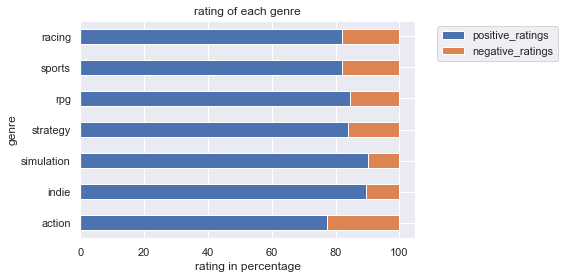

In [43]:
genreRating.plot(kind = 'barh', stacked = True)
plt.legend(bbox_to_anchor=(1.05,1))
plt.title("rating of each genre")
plt.xlabel("rating in percentage")

we can see that simulation and indie have a lot more postive ratings compared to the rest. We thought that action would receive more postive rating as it is considered the most popular genre. The reason why simulation and indie has more postive rating may be due to factors such as lenghth of game play and content of the game which we will explore later.

### Reviews

In [44]:
#steamCombinedReviews_Title_Reviews

In [45]:
#NUM_TOP_WORDS = 20
#top_20 = hero.visualization.top_words(news_content['clean_content']).head(NUM_TOP_WORDS)# Draw the bar chart
#top_20.plot.bar(rot=90, title="Top 20 words");
#plt.show(block=True);
